In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
x=[]
y=[]
c=0
zeros = 0
import numpy as np
import os
for file in os.listdir("/kaggle/input/contrails-images-ash-color/contrails"):
    if(c<2000): #Initially Considering Only 1000 Images. Will Be Scaling Up Later.
        a=np.load("/kaggle/input/contrails-images-ash-color/contrails/"+file)
        xa=a[:,:,:3]
        ya=a[:,:,3]
        if(np.sum(ya)>1000 and (c-zeros) <1500):
            x.append(xa.astype('float32'))
            y.append(ya.astype('float32'))
            c+=1
        elif(1 not in ya and zeros<500):
            x.append(xa.astype('float32'))
            y.append(ya.astype('float32'))
            zeros+=1
            c+=1
    else:
        break

In [2]:
x=np.array(x)
y=np.array(y)
print(x.shape)
print(y.shape)

(2000, 256, 256, 3)
(2000, 256, 256)


In [3]:
y = y.reshape(2000,256,256,1)

In [4]:
!pip install -U -q segmentation-models
!pip install -q tensorflow
!pip install -q keras
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Segmentation Models: using `tf.keras` framework.


In [17]:
import tensorflow as tf
import cv2 
import numpy as np
import matplotlib.pyplot as plt
BACKBONE = 'efficientnetb5'

In [9]:
import segmentation_models
from segmentation_models import Unet
from keras import backend as K
def dice_loss(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    total_pixels = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice_coefficient = (2. * intersection + smooth) / (total_pixels + smooth)
    return 1. - dice_coefficient

In [18]:
model = Unet(BACKBONE,input_shape = (256,256,3),encoder_weights='imagenet',encoder_freeze=True)
#Using 'resnet34'(Residual Network) architecture as backbone architecture 
#Using encoder_weights(feature detector values) from the popular 'Imagenet' dataset , a kind of pre trainded weights
model.compile(optimizer='adam',loss=dice_loss,metrics=['accuracy'])
print(model.summary())

115515256/115515256 [==============================] - 6s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 48  1296        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 48  192         ['stem_conv[0][0]']              
                         

In [11]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=10)
print('Training Set Size ',len(xtrain))
print('Testing Set Size ',len(xtest))

Training Set Size  1600
Testing Set Size  400


In [19]:
results = model.fit(xtrain,ytrain,validation_split=0.2,batch_size=25,epochs= 40)

Epoch 1/40


2023-07-25 14:35:16.521128: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


52/52 [==============================] - 101s 727ms/step - loss: 0.8159 - accuracy: 0.8185 - val_loss: 0.8931 - val_accuracy: 0.6033
Epoch 2/40
52/52 [==============================] - 31s 598ms/step - loss: 0.6273 - accuracy: 0.9531 - val_loss: 0.7767 - val_accuracy: 0.9659
Epoch 3/40
52/52 [==============================] - 31s 597ms/step - loss: 0.5715 - accuracy: 0.9782 - val_loss: 0.7268 - val_accuracy: 0.9808
Epoch 4/40
52/52 [==============================] - 30s 587ms/step - loss: 0.5489 - accuracy: 0.9805 - val_loss: 0.7386 - val_accuracy: 0.9808
Epoch 5/40
52/52 [==============================] - 30s 587ms/step - loss: 0.4810 - accuracy: 0.9799 - val_loss: 0.9054 - val_accuracy: 0.6899
Epoch 6/40
52/52 [==============================] - 31s 596ms/step - loss: 0.4403 - accuracy: 0.9783 - val_loss: 0.6647 - val_accuracy: 0.9769
Epoch 7/40
52/52 [==============================] - 31s 596ms/step - loss: 0.4218 - accuracy: 0.9789 - val_loss: 0.5710 - val_accuracy: 0.9642
Epoch 8/4

In [20]:
y_pred = model.predict(xtest)
y_pred_thresholded = y_pred > 0.5
print(ytest.dtype)
print(y_pred_thresholded.dtype)
intersection = np.logical_and(ytest,y_pred_thresholded)
union = np.logical_or(ytest,y_pred_thresholded)
iou_score = np.sum(intersection)/np.sum(union)
print("IoU score is:",iou_score)


13/13 [==============================] - 9s 276ms/step
float32
bool
IoU score is: 0.422778544856167


In [24]:
test_img = xtest[19]
test_img = cv2.cvtColor(test_img,cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img,axis=0)
print(test_img.shape)
prediction=model.predict(test_img)
print(prediction.shape)
prediction = prediction.reshape(256,256,1)
print(ytest[19].shape)


(1, 256, 256, 3)
1/1 [==============================] - 0s 40ms/step
(1, 256, 256, 1)
(256, 256, 1)


2461.0803


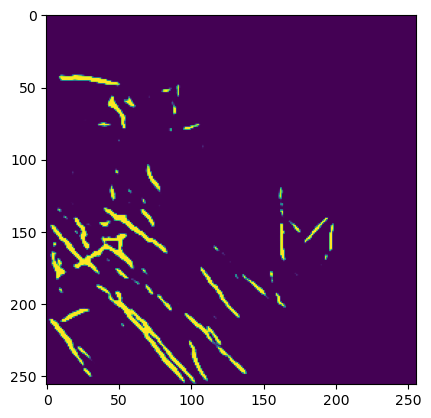

In [26]:
plt.imshow(prediction)
print(np.sum(prediction))
#predicted image

623606.0


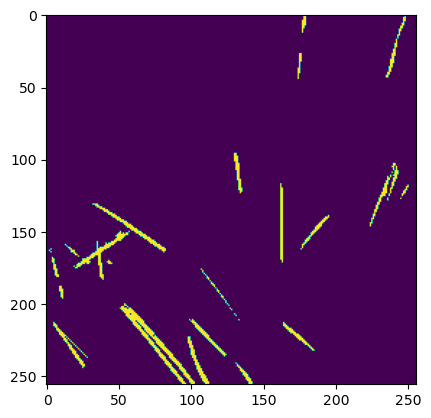

In [25]:
plt.imshow(ytest[19])
print(np.sum(ytest))
#Actual image 

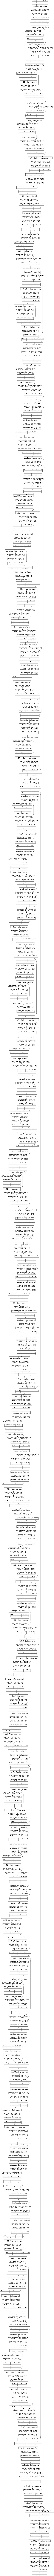

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)